# Extract Largest Eigenvalue of Symmetric Matrix with a Neural Network

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube

In [3]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

In [4]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

In [5]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=torch.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * torch.rand(1) + xmin  
        y = (pmax - pmin) * torch.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.asarray(ran)  

def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

def eigenvalue_of_eigenvector(x):
    return ((x @ A @ x.T) / (x @ x.T)).item()

### ODE specification

In [76]:
#A = generate_random_symmetric_matrix(dim)
A = torch.tensor(1/4 * np.array([[1,2,3,4,5],[2,-1,-2,-3,-4],[3,-2,1,1,1],[4,-3,1,0,0],[5,-4,1,0,0]]))
dim = A.shape[-1]
print(f"A = {A}")

# Coordinate transformations to bring the infinite time domain t \in [0,inf) to tau \in [0,1)
def dtau_dt_inv_tan(tau):
    """
    Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
    """
    return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

def dtau_dt_inv_arctanh(tau):
    """
    Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
    """
    return 1.0/(1.0 - tau**2)

# Random intial vector as initial condition. Function attributes used to fix the random vector across calls
def ic(y, tau):
    return y - ic.y0, torch.zeros_like(y)
ic.y0 = torch.rand(dim).reshape(1,-1)
ic.y0 /= torch.sqrt(ic.y0 @ ic.y0.T).item()

# We can interpret the conservation property (d/dtau (y@y.T) = 0) of the ODE as boundary condition. 
# Note that we compare against a scalar property (the norm) and not a vector. Hence the difference in 
# the second return argument compared to ic() or eigenvector_ode()
def norm_conservation(y, tau):
    return torch.sqrt((y[:,None,:] @ y[:,:,None]).squeeze(-1)), torch.ones_like(tau)

def eigenvector_ode(y, tau):    
    # Left hand side (LHS) of ODE
    y_tau = derivative(y, tau)
    # Right hand side (RHS) of ODE
    first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * A)).squeeze()
    second_term = (y[:,None,:] @ A @ y[:,:,None] @ y[:,None,:]).squeeze()
    #Prefactor of LHS due to coordinate transformation
    dtau_dt_inv = dtau_dt_inv_tan(tau)
    return y_tau - dtau_dt_inv * (first_term - second_term), torch.zeros_like(y)
eigenvector_ode.domain_dim=1
eigenvector_ode.target_dim=dim
    
def temporal_sample(T, N_t, kind="lhs", function=dtau_dt_inv_tan):
    if kind == "lhs":
        sampler = lambda N: torch.from_numpy(T * LatinHypercube(1).random(n = N))
    elif kind == "uniform":
        sampler = lambda N: torch.from_numpy(np.linspace(0.01, .99*T, N).reshape(-1,1))
    elif kind == "rejection":
        sampler = lambda N: torch.from_numpy(rejection_sampling(function, n=N, xmin=0.01, xmax=.99*T)).reshape(-1,1)
    
    #Interior points
    samples_t = sampler(N_t)
    
    # Initial condition
    samples_t_ic = torch.tensor([0.]).reshape(-1,1)
    
    return samples_t, \
           samples_t_ic, \
           samples_t

A = tensor([[ 0.2500,  0.5000,  0.7500,  1.0000,  1.2500],
        [ 0.5000, -0.2500, -0.5000, -0.7500, -1.0000],
        [ 0.7500, -0.5000,  0.2500,  0.2500,  0.2500],
        [ 1.0000, -0.7500,  0.2500,  0.0000,  0.0000],
        [ 1.2500, -1.0000,  0.2500,  0.0000,  0.0000]])


torch.Size([512, 1]) torch.Size([1, 1]) torch.Size([512, 1])


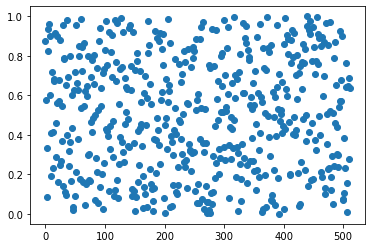

In [77]:
#IBVP parameters
N_interior =  2**9
T = 1

# Generate training set
X_train = temporal_sample(T, N_interior, kind="lhs")
t_int, t_ic, t_bc = X_train
print(t_int.shape, t_ic.shape, t_bc.shape)

# Generate test data
X_test = temporal_sample(T, N_interior, kind="lhs")

plt.scatter(np.arange(N_interior), t_int)
plt.show()

In [87]:
hp = {"optimizer":"adam", "epochs":1000}
eigen_nn = PiNN(eigenvector_ode, ic, norm_conservation, verbose=True, hyperparameters=hp)
print(eigen_nn)
eigen_nn.fit(X_train, None)

NN(
  (ff_graph): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
  )
  (output): Linear(in_features=20, out_features=5, bias=True)
)
model parameters:                                                  985
---------------------------Hyperparameters----------------------------
hidden_layers                                             [20, 20, 20]
epochs                                                            1000
number_of_minibatches                                                1
optimizer                                                         adam

-----------------------------Training Log-----------------------------
# of collocation points:                                           512
# of boundary points:                                              512
# of initial condition:            

In [82]:
#Ground Truth
eigenvalues, eigenvectors = np.linalg.eig(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")

max{ Sp(A) } = 2.2536651627025712


In [84]:
x = eigen_nn.predict(torch.tensor([1.]).reshape(1,1))
x_0 = eigen_nn.predict(torch.tensor([0.]).reshape(1,1))
print(f"network = {eigenvalue_of_eigenvector(x)}")
print(f"network ic = {x_0 @ x_0.T}")
print(f"ic = {ic.y0 @ ic.y0.T}")

network = 0.0171181310575181
network ic = tensor([[0.8621]])
ic = tensor([[1.0000]])
